# Part 2 Maximise Profit
* We calculate the profit for each customer based on whether they have subscribed to the product
* Using a classifier as before we predict the set of subscribers
* Order the probability of predicting subscription and bin it according to population
* Calculate the cumlative sum of profit in each population decile
* Identify the maximum profit and the corresponding population percentile

In [1]:
from feature_engineering import *

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font='Lato', font_scale=1.5)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import (RandomForestClassifier, RandomTreesEmbedding, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, auc

In [107]:
def predict_profit(X, profit, clf, bins=20):
    """
    Estimate total profit as a percentage of the population called.
    
    """
    predicted_df = pd.DataFrame()
    predicted_df['profit'] = profit
    predicted_df['proba'] = clf.predict_proba(X)[:, 1]
    predicted_df['bin_positive'] = pd.qcut(predicted_df['proba'], bins)
    binned_profit = []
    for bin_id, data in predicted_df.groupby('bin_positive'):
        binned_profit.append(data['profit'].sum())
    binned_profit.append(0)
    return np.array(binned_profit[::-1]).cumsum()

In [4]:
new_feature_target_file = '../output/bank_all_features_target.csv'

In [5]:
full_df = pd.read_csv(new_feature_target_file)

### Extract features from DataFrame

In [6]:
features_df, target = extract_features_target(full_df)

## NEW: Define `profit` column for each entry
Objective is to maximise the sum of the `profit` column by correctly identifying the target

In [47]:
profit = target*features_df['balance']*0.01-1
features_df['profit'] = profit

In [13]:
RANDOM_SEED=42

In [52]:
X_train_prof, X_test_prof, y_train, y_test = train_test_split(features_df.values, target, test_size=0.2)

In [53]:
# Extract the features and the profit columns
X_train = X_train_prof[:,:-1]
X_test = X_test_prof[:,:-1]
train_prof = X_train_prof[:,-1]
test_prof = X_test_prof[:,-1]

### Train logistic regression, random forest and gradient boosting classifiers

In [81]:
RANDOM_STATE=42

In [116]:
lr = LogisticRegression(C=10)
lr_pipe = make_pipeline(StandardScaler(), LogisticRegression(C=10))
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [119]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight={0: 1, 1:3}, max_depth=10, max_features=50, n_estimators=50)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 3},
            criterion='gini', max_depth=10, max_features=50,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [82]:
gbrt = GradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=5, n_estimators=200)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

### Predict the profit

In [120]:
binned_profit_lr = predict_profit(X_test, test_prof, lr_pipe)
binned_profit_rf = predict_profit(X_test, test_prof, rf)
binned_profit_gbrt = predict_profit(X_test, test_prof, gbrt)

In [114]:
percent_called = np.arange(21)*5

### Plot profit curve

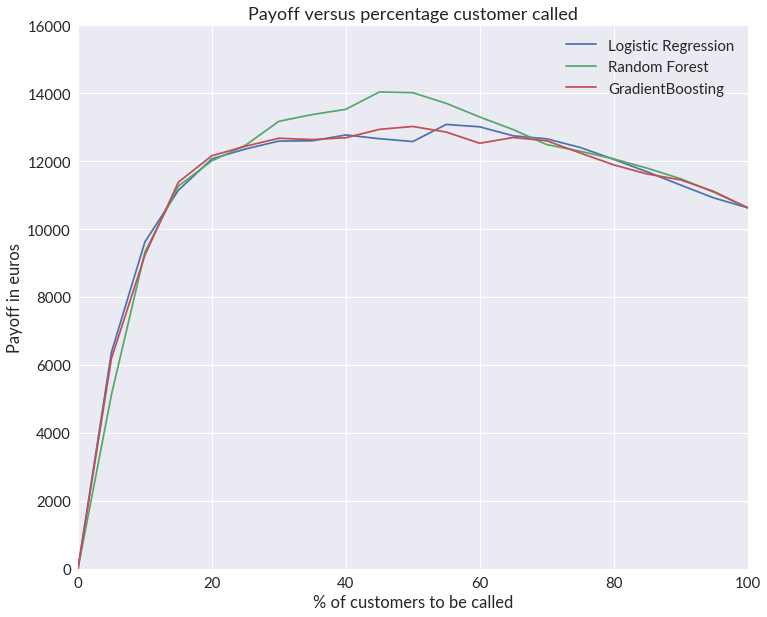

In [124]:
plt.figure(figsize=(12, 10))
plt.plot(percent_called, binned_profit_lr, label='Logistic Regression')
plt.plot(percent_called, binned_profit_rf, label='Random Forest')
plt.plot(percent_called, binned_profit_gbrt, label='GradientBoosting')
plt.title('Payoff versus percentage customer called')
plt.xlabel('% of customers to be called')
plt.ylabel('Payoff in euros')
plt.xlim(0, 100)
plt.ylim(0, 16000)
plt.legend()

## Estimated total profit

In [129]:
max_profit_in_test_data = 14000
total_num_customers = 1.e7
total_in_test_data = len(test_prof)
profit_in_millions = total_num_customers/total_in_test_data * max_profit_in_test_data / 1.e6
print("Estimated profit for the total population in millions: {:.2f}".format(profit_in_millions))

Estimated profit for the total population in millions: 15.48
